In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################

batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

modes = 5
width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [3]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/complete_data')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['noise_0005'])
#mes = np.asarray(raw_data['measurement_data'])

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))

# dimensions of solution space
y_dim1 = 16
y_dim2 = 16

# dimensions of measurement space
x_dim2 = 8     # no of detectors
x_dim1 = int(mes.shape[1]/x_dim2)

def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_normalizer = UnitGaussianNormalizer(y_train)
#y_train = y_normalizer.encode(y_train)

#x_normalizer = UnitGaussianNormalizer(X_train)
#X_train = x_normalizer.encode(X_train)
#X_test = x_normalizer.encode(X_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_test = y_test.reshape(y_test.shape[0],y_dim1,y_dim2,1)
y_train = y_train.reshape(y_train.shape[0],y_dim1,y_dim2,1)

X_test = X_test.reshape(X_test.shape[0], x_dim1,x_dim2,1)
X_train = X_train.reshape(X_train.shape[0], x_dim1,x_dim2,1)

#batch_size = 10
#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print(X_train.shape, y_train.shape)

torch.Size([8000, 8, 8, 1]) torch.Size([8000, 16, 16, 1])


In [30]:
#   DEFINING THE TOP 2D FOURIER LAYER
#####################################################################
#   DEFINING THE TOP 2D FOURIER LAYER

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        #print('input',input.shape)
        #print('weights',weights.shape)
        #print("bixy,ioxy->boxy")
        R_out = torch.einsum("bixy,ioxy->boxy", input, weights)
        #print(R_out.shape)
        return R_out

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        #print('what is out_ft', out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [5]:
# MODELS
####################################### MODELS ###############################
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)



################################ 1 FOURIER LAYER NETWORK ARCHITECTURE ###########################################

class FNO2d_1L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_1L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)



############################ 2 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO2d_2L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_2L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        #self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        #self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        #self.w2 = nn.Conv2d(self.width, self.width, 1)
        #self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)






############################ 4 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO2d_4L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_4L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


############################ 6 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO2d_6L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_6L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv5 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)



        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)





############################ 8 FOURIER LAYER NETWORK ARCHITECTURE #############################################
class FNO2d_8L(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_8L, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(1, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv5 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv6 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv7 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)
        self.w6 = nn.Conv2d(self.width, self.width, 1)
        self.w7 = nn.Conv2d(self.width, self.width, 1)



        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2
        x = F.gelu(x)


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv6(x)
        x2 = self.w6(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv7(x)
        x2 = self.w7(x)
        x = x1 + x2
        
        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [31]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

In [32]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 
# torch.save(model, 'model/ns_fourier_burgers')

# scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})

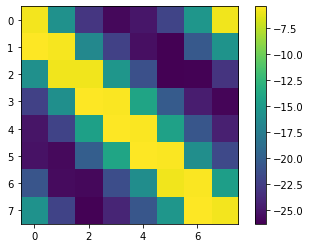

In [7]:
# MEAUSREMENT DATA

test_num = 434
truth_out = test_loader.dataset[test_num][0]
plt.imshow(np.reshape(truth_out.numpy(),(8,8)))
plt.colorbar()


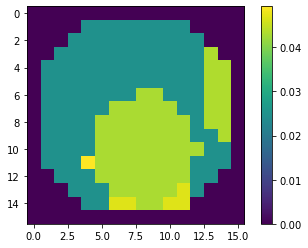

In [33]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

save_recon = 'truth.png'
plt.savefig('./images/' + save_recon)

In [9]:
# ONE LAYER RESULTS
############################################################################

#model_1L = FNO2d(modes, modes, width).cuda()
#print(count_params(model_1L))
#output_1L = train_model(model_1L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

#output_1L_model = output_1L.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
#results_1L = model_metrics(output_1L_model,test_loader,ntrain)

# ONE LAYER RESULTS
############################################################################
#K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
#output_1L_model.eval()
#predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
#plt.imshow(predicted)

In [10]:
#K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
#output_1L_model.eval()
#predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
#plt.imshow(predicted)

422724
0 9.794340099906549 1.3290477869212627 0.5577644288539887
1 4.574013900011778 0.3824121780693531 0.26358320224285126
2 4.467210200033151 0.2823208349198103 0.2523985337615013
3 4.63125229999423 0.26208556185662746 0.25139807391166685
4 4.562501500011422 0.2574003166109323 0.24877113938331605
5 4.451156000024639 0.2520346444398165 0.2465552344918251
6 4.4412303999997675 0.3658910105377436 0.27206712794303894
7 4.562585499952547 0.2715930382460356 0.26199138385057447
8 4.592083499999717 0.25964544306695464 0.2504536207318306
9 4.48261750000529 0.24995105814933777 0.2535714071393013
10 4.479636700008996 0.24342993825674056 0.23606341856718063
11 4.440621200017631 0.23894135497510433 0.23724817699193954
12 4.43372420000378 0.23281741054356098 0.2295490726828575
13 4.43769690010231 0.23059505854547024 0.22308757472038268
14 4.437184799928218 0.22491437138617038 0.2297427288889885
15 4.411237600026652 0.22171298353374005 0.21795593577623368
16 4.443740400020033 0.21759522275626658 0.2

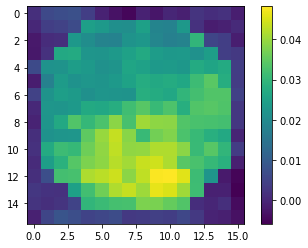

In [11]:
# ONE LAYER RESULTS
############################################################################

model_1L = FNO2d_1L(modes, modes, width).cuda()
print(count_params(model_1L))
output_1L = train_model(model_1L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_1L_model = output_1L.get("model")
torch.save(output_1L_model, 'fno2D_1l.h5')
results_1L = model_metrics(output_1L_model,test_loader,ntrain)

# ONE LAYER RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

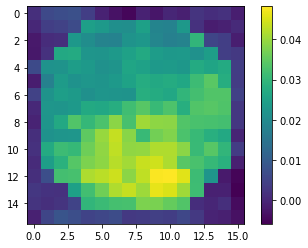

In [12]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_1lv2_noise1.png'
plt.savefig('./images/' + save_recon)

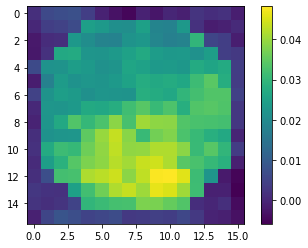

In [13]:
# ONE LAYER RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

836484
0 6.941814800025895 0.4646707601249218 0.19145236653089523
1 6.917188199935481 0.1801858006864786 0.17002258318662644
2 6.822607700014487 0.1699254598170519 0.16462992215156555
3 6.68917250004597 0.15661529450118541 0.1450409534573555
4 6.676108099985868 0.14958981613069772 0.1460211547613144
5 6.6611462000291795 0.14170352140814066 0.13224808159470558
6 6.634584199986421 0.13686355017125607 0.13029095610976218
7 6.620902099995874 0.13395922911912203 0.13064460599422456
8 6.6483334000222385 0.13214602766185998 0.13750721883773803
9 6.662035300047137 0.12902079429477453 0.12642862159013749
10 7.097785499994643 0.12796651662141084 0.12477151161432266
11 6.847392899915576 0.12717814330011606 0.1251552617251873
12 7.0436110000591725 0.12547313542664051 0.1257230550944805
13 7.101009800098836 0.1249429270401597 0.12427908703684806
14 7.374702500062995 0.12289578704535961 0.12203203502297401
15 6.993005199939944 0.12274600313603878 0.12267690253257751
16 7.237649600021541 0.1209605788

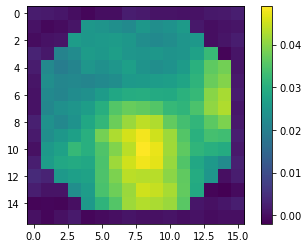

In [14]:
# TWO LAYER RESULTS
############################################################################

model_2L = FNO2d_2L(modes, modes, width).cuda()
print(count_params(model_2L))
output_2L = train_model(model_2L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_2L_model = output_2L.get("model")
torch.save(output_2L_model, 'fno2d_2l.h5')


results_2L = model_metrics(output_2L_model,test_loader,ntrain)

# TWO LAYER RESULTS
############################################################################
output_2L_model.eval()
predicted = np.reshape(output_2L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

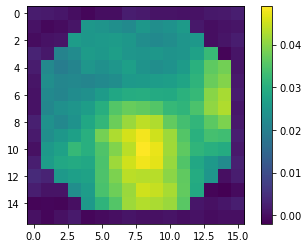

In [15]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_2L_model.eval()
predicted = np.reshape(output_2L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_2lv2_noise1.png'
plt.savefig('./images/' + save_recon)

1664004
0 11.53988129994832 0.20817748545110226 0.13479715937376022
1 11.179134899983183 0.1309011548012495 0.12460026419162751
2 11.328476900001988 0.12211438451707363 0.12583342680335044
3 11.52755600004457 0.11706228311359883 0.11273139411211014
4 11.252054099924862 0.11383373030275107 0.11121402937173844
5 11.126373399980366 0.11134953787922859 0.1109261523783207
6 11.280955799971707 0.10891775391250849 0.10607392728328705
7 11.411282800021581 0.10717372242361307 0.10697859013080598
8 11.29527160001453 0.10571434028446675 0.10566304343938827
9 11.40699799999129 0.10396190100163222 0.10548530280590057
10 11.297323900042102 0.10248125375807285 0.10177650517225266
11 11.284639099962078 0.10188814898580313 0.10199160465598106
12 11.159031599992886 0.10050670403987169 0.10136565640568733
13 11.085872299969196 0.09906245137751102 0.10300483161211013
14 11.2644372000359 0.09733034472167491 0.09950141131877899
15 11.684985399944708 0.09700043939054012 0.10125337585806847
16 11.887202200014

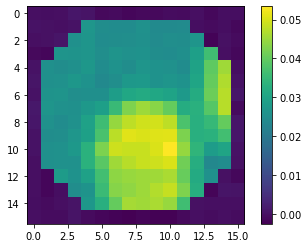

In [16]:
# FOUR LAYER RESULTS
############################################################################

model_4L = FNO2d_4L(modes, modes, width).cuda()
print(count_params(model_4L))
output_4L = train_model(model_4L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_4L_model = output_4L.get("model")
torch.save(output_4L_model, 'fno2d_4l.h5')


results_4L = model_metrics(output_4L_model,test_loader,ntrain)

# FOUR LAYER RESULTS
############################################################################
output_4L_model.eval()
predicted = np.reshape(output_4L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

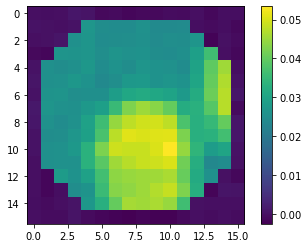

In [17]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_4L_model.eval()
predicted = np.reshape(output_4L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_4lv2_noise1.png'
plt.savefig('./images/' + save_recon)

2491524
0 16.22172250004951 0.19309264247119426 0.14270004498958588
1 16.461498399963602 0.1258981437087059 0.11592787045240402
2 15.980207500047982 0.11696310199797154 0.1227042161822319
3 15.868658400024287 0.11284030123800039 0.10947680819034576
4 15.688209400046617 0.10948054364323616 0.1093569161593914
5 15.701828299905173 0.10673747373372316 0.1127939109504223
6 15.6838931000093 0.1036062702909112 0.10518633356690407
7 15.76240779994987 0.10142515593767167 0.10210587939620018
8 15.996432999963872 0.09829668103158475 0.09924885427951813
9 15.5983891999349 0.09793764147162437 0.09704065811634063
10 15.604636100004427 0.09511645583063363 0.09540511548519134
11 15.747684100060724 0.09406480388343334 0.09411133766174316
12 15.728705699904822 0.09327989625185729 0.09464239203929901
13 15.820443399949 0.09189943027496338 0.09308667102456093
14 15.781898900051601 0.09145977549254894 0.09419346424937249
15 15.597973600029945 0.08998054313659667 0.09689006325602531
16 15.513855600031093 0.

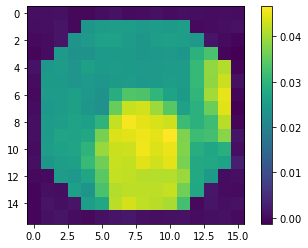

In [18]:
# SIX LAYER RESULTS
############################################################################

model_6L = FNO2d_6L(modes, modes, width).cuda()
print(count_params(model_6L))
output_6L = train_model(model_6L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_6L_model = output_6L.get("model")
torch.save(output_6L_model, 'fno2d_6l.h5')


results_6L = model_metrics(output_6L_model,test_loader,ntrain)

# SIX LAYER RESULTS
############################################################################
output_6L_model.eval()
predicted = np.reshape(output_6L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

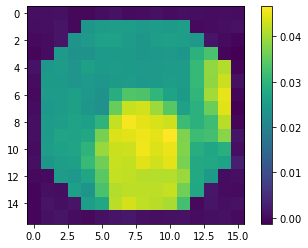

In [19]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_6L_model.eval()
predicted = np.reshape(output_6L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_6lv2_noise1.png'
plt.savefig('./images/' + save_recon)

In [34]:
# EIGHT LAYER RESULTS
############################################################################

model_8L = FNO2d_8L(modes, modes, width).cuda()
print(count_params(model_8L))
output_8L = train_model(model_8L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_8L_model = output_8L.get("model")
torch.save(output_8L_model, 'fno2d_8l.h5')


results_8L = model_metrics(output_8L_model,test_loader,ntrain)

# EIGHT LAYER RESULTS
############################################################################
output_8L_model.eval()
predicted = np.reshape(output_8L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

3319044
0 20.369963299948722 0.1865797242373228 0.141379176735878


KeyboardInterrupt: 

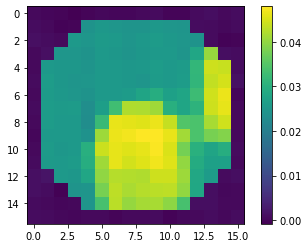

In [21]:
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_8L_model.eval()
predicted = np.reshape(output_8L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

save_recon = 'fno2d_8lv2_noise1.png'
#plt.savefig('./images/' + save_recon)

In [22]:
np.mean(results_8L.get('ssim')), np.std(results_8L.get('ssim'))

(0.9078563346863002, 0.03828982048894648)


1 Layer
1663874
TOTAL TIME: ---104.38236680000045
RMSE: ---0.003333161725894805---0.0014171824567482318
PSNR: ---24.067089899473018---2.413291335653067
SSIM: ---0.8197815650537099---0.04497284891212154
UQI: ---0.9915629132112711---0.005649804945150558


2 Layers
1663874
TOTAL TIME: ---143.48116810000647
RMSE: ---0.0027410914288945065---0.0011752522343180846
PSNR: ---25.95367455584884---2.5063768173878174
SSIM: ---0.8848788476675741---0.029903798962027727
UQI: ---0.9943801326523857---0.003707518941374275

4 Layers
1663874
TOTAL TIME: ---227.48713970000608
RMSE: ---0.002347279514966445---0.0011405515295433307
PSNR: ---27.147017014638685---3.243962829021885
SSIM: ---0.9145873484188117---0.031239407287163026
UQI: ---0.9958147433170024---0.0033591851001756


6 Layers
2491394
TOTAL TIME: ---307.26531749999776
RMSE: ---0.002281007437099186---0.0011749824330908503
PSNR: ---27.458660881427257---3.5743994881985213
SSIM: ---0.9198570618445581---0.03522675931308244
UQI: ---0.9958861323842791---0.003541185767768024


8 Layers
3318914
TOTAL TIME: ---395.32088559999465
RMSE: ---0.0022373626727182337---0.001182591818362234
PSNR: ---27.794198608356076---3.699650379845133
SSIM: ---0.9288647265634355---0.03427569857412951
UQI: ---0.996174387737361---0.0033645843224606




<function matplotlib.pyplot.show(close=None, block=None)>

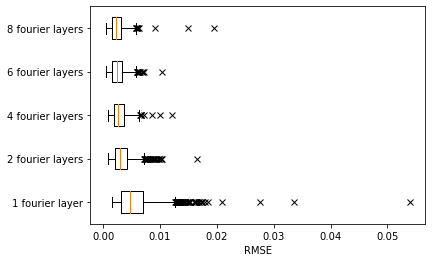

In [23]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("rms"), results_2L.get("rms"), results_4L.get("rms"), results_6L.get("rms"), results_8L.get("rms"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('RMSE')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

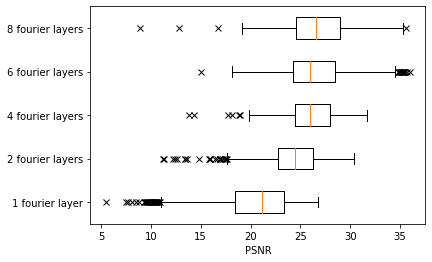

In [24]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("psnr"), results_2L.get("psnr"), results_4L.get("psnr"), results_6L.get("psnr"), results_8L.get("psnr"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('PSNR')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

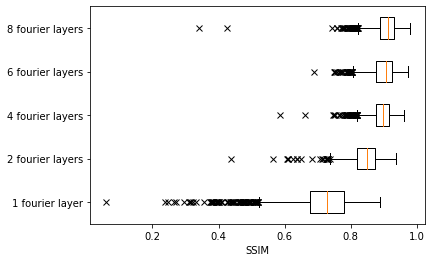

In [25]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("ssim"), results_2L.get("ssim"), results_4L.get("ssim"), results_6L.get("ssim"), results_8L.get("ssim"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.xlabel('SSIM')
plt.show

# Loading in Models

In [26]:
# loading our chosen model 

model = torch.load( './models/fno2d_8l.h5')

In [27]:
# printing out he results of our saved model
results = model_metrics(model,test_loader,ntrain)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 3x64)

In [ ]:
metric_name = 'ssim'        # rms, psnr, ssim

fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results.get(metric_name))

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.xlabel(metric_name)
plt.show

In [ ]:
# Create outlier range
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
outliers = [q25-1.5*iqr,q75+1.5*iqr]

# zip data
data_no = range(len(data))
listed_data = zip(data_no,data)

data_list = list(listed_data)

In [ ]:
print('outliers are anything below ',outliers[0],' or above ',outliers[1])

outlier_list = []
for i in range(len(data)):
    if data_list[i][1] < outliers[0]:
        outlier_list.append(data_list[i])
    elif data_list[i][1] > outliers[1]:
        outlier_list.append(data_list[i])

In [ ]:
print('the number of outliers are ',len(outlier_list) )
#worst reconstruction
worst = [np.min(np.asarray(outlier_list)[:,1]), np.max(np.asarray(outlier_list)[:,1]) ]
print('for outliers, the lowest metric value is ',worst[0],' and highest is', worst[1])

# The values for the worst performers! 
for i in range(len(outlier_list)):
    if outlier_list[i][1] ==  worst[0]:
        print(outlier_list[i])
    elif outlier_list[i][1] == worst[1]:
        print(outlier_list[i])



In [ ]:
print(outlier_list)

In [ ]:
test_num = 76
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

In [ ]:
# Quickly showing that our model gives expected results. 
model.eval()
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(model(K).detach().cpu().numpy(),(16,16))

plt.imshow(predicted)
plt.colorbar()

# Dealing with Panda's Data Frames

In [ ]:
import pandas as pd

In [ ]:
df_fno1d = pd.read_pickle('ssim_fno1')

In [ ]:
df_fno2d = pd.DataFrame(outlier_list, columns =['Image_No', 'ssim_score' ])

In [ ]:
df1_len = df_fno1d.shape[0]

comparison = []
for i in range(df1_len):
    if df_fno1d.loc[:,'Image_No'][i] in df_fno2d['Image_No'].unique():
        temp1 = df_fno2d.loc[:,'Image_No'][i]
        temp2 = df_fno2d.loc[:,'ssim_score'][i]
        temp3 = df_fno1d.loc[:,'ssim_score'][i]
        comparison.append([temp1,temp2,temp3])




In [ ]:
len(comparison)

In [ ]:
comparison